In [4]:
%load_ext autoreload
%autoreload 2

In [216]:
import matplotlib.pyplot as plt
from pathlib import Path
from RaTag.dataIO import *
from RaTag.plotting import *
from RaTag.datatypes import SetPmt, CalibrationResults
import RaTag.constructors as constr
from RaTag.analysis import fit_set_s2

from dataclasses import replace

from lmfit.models import GaussianModel

In [172]:
base_dir = Path('/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/')

X-ray calibration module:
- Fit gaussian to X-ray histogram and extract mean value
- From $E_\gamma$ (12.3 keV), compute $N_e^{exp}$
- Compute $g_{S2} = A_x / N_e^{exp}$
- For the ion (Ra) recoil, compute $N_e^{meas}$ for each set (field $E_d$)
- Normalize ion S2 area: $A_{ion}(E_d) / A_x$
- Compute recombination factor $r = 1 - N_e^{meas}/N_e^{exp}$

# Load X-ray data

In [162]:
run8 = Run(
    root_directory = base_dir,
    run_id = "RUN8",
    el_field = 2375,            # V/cm
    target_isotope = "Th228",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 1e9,
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm

    width_s2 = 20,                # µs 
    W_value = 22.0,               # eV per e-ion pair (gas Xe @ 2 bar)
    E_gamma_xray = 12.3e3,        # eV X-ray energy (for Th228 decay)
)

In [175]:
run8 = constr.populate_run(run8)

In [138]:
from math import e
from sympy import flatten

xray_area = []
for set in run8.sets:
    print(set.source_dir)
    try:
        xres = np.load(set.source_dir / 'xray_results.npy', allow_pickle=True).item()
        areas = np.array([event.area for wfm in xres.events for event in wfm if event.accepted])
        xray_area.append(areas)
    except Exception as e:
        print(f'No xray results found for set: {set.source_dir}, {e}')
xray_area = np.array(flatten(xray_area))

/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate050_Anode1950
/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate100_Anode2000
/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate200_Anode2100
/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate300_Anode2200
/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate400_Anode2300
/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate500_Anode2400
No xray results found for set: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate500_Anode2400, Ran out of input
/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate600_Anode2500
No xray results found for set: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate600_Anode2500, [Errno 2] No such file or directory: '/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate600_Anode2500/xray_results.npy'


In [139]:
xray_area

array([0.06457267, 0.06272467, 0.1368577 , ..., 0.08069995, 0.06675359,
       0.03641729])

## Fit full X-ray histogram

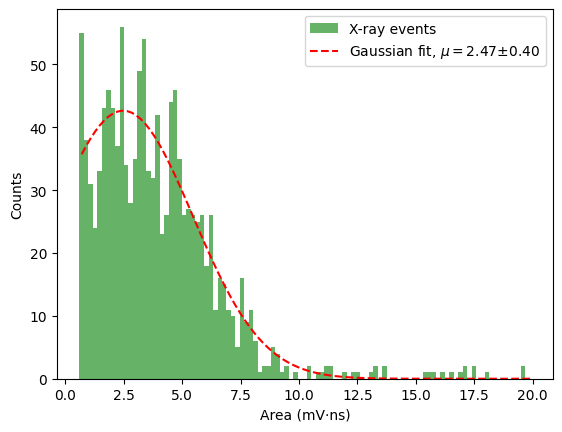

In [ ]:
bin_cuts = (0.6, 20)
nbins = 100

xray_area = xray_area[(xray_area >= bin_cuts[0]) & (xray_area <= bin_cuts[1])]
n, bins = np.histogram(xray_area, bins=nbins, range=(bin_cuts[0], bin_cuts[1]))
cbins = 0.5 * (bins[1:] + bins[:-1])

model = GaussianModel()
params = model.make_params(amplitude=n.max(),
                            center=np.mean(cbins),
                            sigma=np.std(cbins))
result = model.fit(n, params, x=cbins)

A_x_mean = result.params["center"].value
sigma_x = result.params["sigma"].value
stderr = result.params["center"].stderr
ci95 = 1.96 * stderr if stderr else None


n, bins, _ = plt.hist(xray_area, bins=nbins, alpha=0.6, color='g', label="X-ray events")
plt.plot(cbins, model.eval(x=cbins, params=result.params), 'r--', label=f'Gaussian fit, $\mu={A_x_mean:.2f}±{ci95:.2f}$')
plt.gca().set(xlabel = 'Area (mV·ns)', ylabel = 'Counts')
plt.legend()

In [167]:


N_e_exp = run8.E_gamma_xray / run8.W_value
g_S2 = A_x_mean / N_e_exp

calib_res = CalibrationResults(
    run_id = run8.run_id,
    A_x_mean = A_x_mean,
    N_e_exp = N_e_exp,
    g_S2 = g_S2
)
# g_S2 = A_x_mean / N_e_exp

In [237]:
calib_res.N_e_exp, calib_res.g_S2

(559.0909090909091, np.float64(0.004424800154911603))

# Load Ion S2 areas

In [217]:
fitted_areas = {}

prep_sets = []
for i, set in enumerate(run8.sets):
    s1 = constr.set_from_dir(set.source_dir)
    s1 = constr.set_fields(s1, drift_gap_cm=run8.drift_gap, el_gap_cm=run8.el_gap, gas_density=run8.gas_density)
    prep_sets.append(s1)
    s2_areas = load_s2area(set)
    fitted_areas[set.source_dir.name] = fit_set_s2(s2_areas,
               bin_cuts = (0, 10), nbins = 100, exclude_index = 1, flag_plot = False)
run8 = replace(run8, sets=prep_sets)

In [209]:
s1.drift_field

428.5714285714286

In [220]:
drift_fields = [s.drift_field for s in run8.sets]

means = [fitted_areas[s.source_dir.name].mean for s in run8.sets]
ci95s = [fitted_areas[s.source_dir.name].ci95 for s in run8.sets]

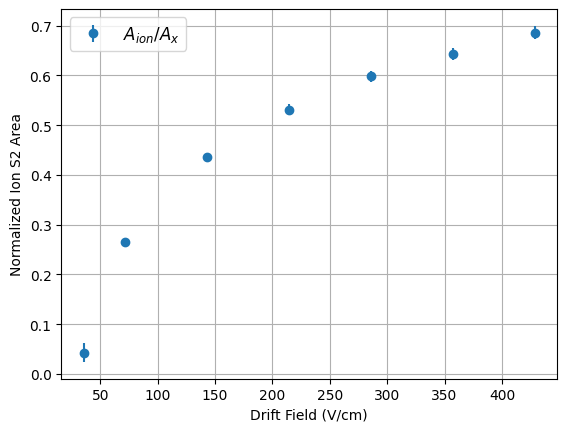

In [ ]:
def plot_normalized_s2_vs_drift(fitter_areas, run):
    A_ion = np.array([fitted_areas[s.source_dir.name].mean for s in run8.sets])
    dA_ion = np.array([fitted_areas[s.source_dir.name].ci95 for s in run8.sets])
    norm_A_ion = A_ion / A_x_mean
    dnorm_A_ion = dA_ion / A_x_mean

    plt.errorbar(drift_fields, norm_A_ion, yerr=dnorm_A_ion, fmt='o', label='$ A_{ion} / A_x$')
    plt.gca().set(xlabel='Drift Field (V/cm)', ylabel='Normalized Ion S2 Area')
    plt.grid(True)
    plt.legend(fontsize=12)

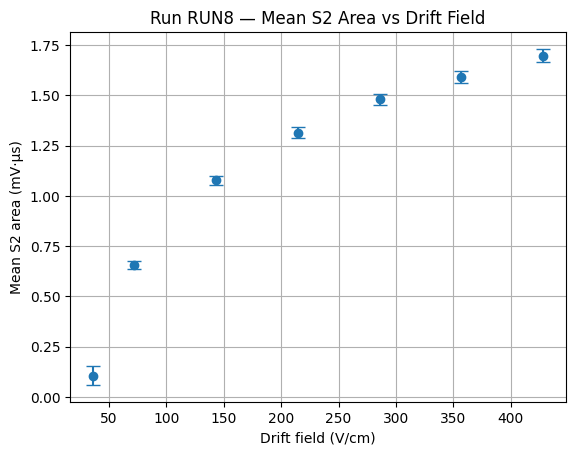

In [221]:
plot_s2_vs_drift(run8, fitted_areas)

In [244]:
N_e_meas[1] / N_e_exp, r[1]

(np.float64(0.264969354071934), np.float64(0.735030645928066))

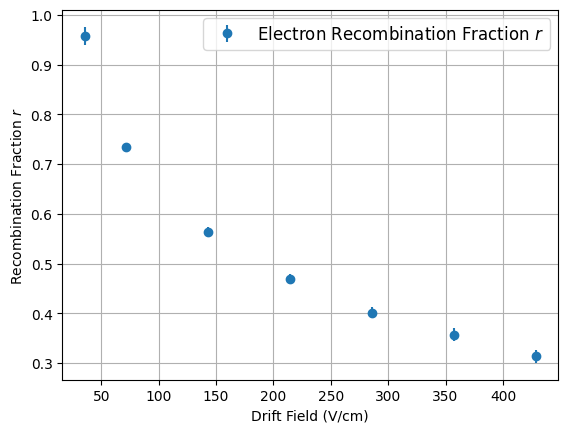

In [236]:
N_e_meas = A_ion / g_S2
dN_e_meas = dA_ion / g_S2

r = 1 - N_e_meas / N_e_exp
dr = dN_e_meas / N_e_exp
plt.errorbar(drift_fields, r, yerr=dr, fmt='o', label='Electron Recombination Fraction $r$')
plt.gca().set(xlabel='Drift Field (V/cm)', ylabel='Recombination Fraction $r$')
plt.grid(True)
plt.legend(fontsize=12)